## Comapre Vibrator Data

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import re
import math
#import imageio.v2 as imageio
from matplotlib.lines import Line2D
from ipywidgets import interact
from scipy.signal import savgol_filter


In [2]:
# --- CONFIG ---
folder_path =  "Data"
ext = ".pkl"

# --- Gather all pickle files ---
pickle_files = [f for f in os.listdir(folder_path) if f.endswith(ext)]

# --- Extract Ratio from filenames using regex ---
def get_ratio_and_vib(file_name):
    ratio_match = re.search(r'Ratio_([\d.]+)', file_name)
    vib_match = re.search(r'Vib_([\d.]+)', file_name)
    
    ratio = float(ratio_match.group(1)) if ratio_match else None
    vib = float(vib_match.group(1)) if vib_match else None
    
    return ratio, vib



# --- Map files to their Ratio group ---
file_params = {file: get_ratio_and_vib(file) for file in pickle_files}
unique_ratios = sorted(set(r for r, vib in file_params.values() if r is not None))

# --- Assign one color per Ratio group ---
cmap = cm.get_cmap('tab10', len(unique_ratios))
ratio_colors = {ratio: cmap(i) for i, ratio in enumerate(unique_ratios)}


def trim_motion_start(displacement, threshold=0.15):
    displacement = np.array(displacement)
    abs_disp = np.abs(displacement)
    
    # Find the first index where displacement exceeds the threshold
    start_idx = np.argmax(abs_disp > threshold)
    
    # In case there's never any motion
    if abs_disp[start_idx] <= threshold:
        return displacement  # Or return np.array([]) if you prefer skipping it
    
    return displacement[start_idx:]

vib_power_map = {
    0:	0.0000,
    5:	0.2604,
    10:	0.2940,
    15:	0.2940,
    20:	0.3444,
    25:	0.3612,
    30:	0.3948,
    35:	0.4116,
    40:	0.4536,
    45:	0.4704,
    50:	0.5040,
    55:	0.5208,
    60:	0.5712,
    65:	0.5964,
    70:	0.6300,
    75:	0.6468,
    80:	0.6888,
    85:	0.7224,
    90:	0.7728,
    95:	0.7896,
    100:	0.8148
} # In watts

## Computes longest distance between dots in pixels, hand measured in cm, compared and used to find ppcm
# About 31.5 pixels per cm

point_A = np.array([835,580])
point_B = np.array([799,74])
distane_pxl = np.linalg.norm(point_A-point_B)
distance_cm = 16.1
ppcm = distane_pxl/distance_cm # pixels per cm

print(f"Pixels per centimeter: {ppcm:.2f}")

Pixels per centimeter: 31.51


C:\Users\Osvaldo A\AppData\Local\Temp\ipykernel_8248\2246472923.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_ratios))


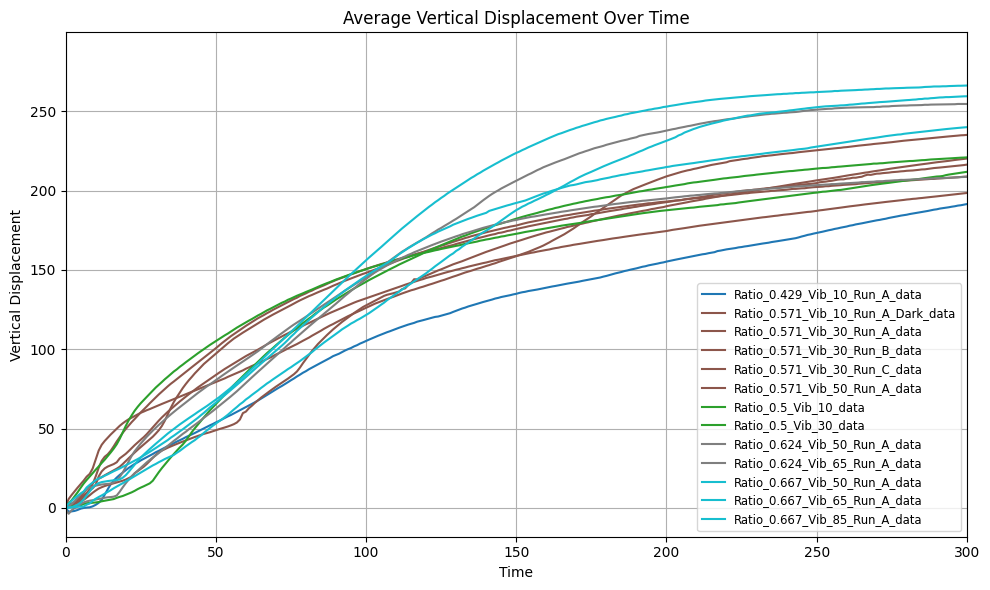

Processed data saved to: Data\cum_pp_displacement_data.pkl


In [3]:



# --- Plot setup ---
fig, ax = plt.subplots(figsize=(10, 6))

# To store the trimmed + averaged displacement data
results = {}


# --- Loop through and plot averaged data per file ---
for file in pickle_files:
    ratio, vib = file_params[file]
    if ratio is None:
        continue  # skip files with no valid ratio
    color = ratio_colors.get(ratio, 'black')  # fallback color
    full_path = os.path.join(folder_path, file)

    with open(full_path, 'rb') as f:
        displacements = pickle.load(f)

    # Trim vertical displacements at start of motion
    trimmed = [trim_motion_start(d[:, 0]) for d in displacements]
    
    # Align lengths by cutting to shortest trimmed signal
    min_len = min(len(d) for d in trimmed)
    trimmed = [d[:min_len] for d in trimmed]

    vertical_mean = np.mean(trimmed, axis=0)


    # Save the trimmed and averaged data
    results[file] = {
        'ratio': ratio,
        'vib': vib,
        'color': color,
        'vertical_mean': vertical_mean,
        'trimmed_raw': trimmed  # Optional: keep the individual trimmed runs too
    }

    label = os.path.splitext(file)[0]
    ax.plot(vertical_mean, label=label, color=color)

# --- Final formatting ---
ax.set_title("Average Vertical Displacement Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Vertical Displacement")
ax.grid(True)
ax.legend(fontsize='small', loc='best')
ax.set_xlim(0,300)
plt.tight_layout()
plt.show()


# Define a path to save the processed results
save_path = os.path.join(folder_path, "cum_pp_displacement_data.pkl")

with open(save_path, 'wb') as f:
    pickle.dump(results, f)

print(f"Processed data saved to: {save_path}")



## Plot R  = Constant, Increasing Power

In [7]:
def plot_trials_by_ratio_subplots(results, vib_power_map, ppcm=31.5, 
                                   limit_type='none', limit_val=10, 
                                   plot_derivative=False, x_axis_type='energy',
                                   start_disp_threshold_cm=0, max=False,
                                   w_size = 5, poly_o = 2):


    # --- Group data by ratio ---
    ratio_groups = {}
    for filename, data in results.items():
        ratio = data['ratio']
        if ratio not in ratio_groups:
            ratio_groups[ratio] = []
        ratio_groups[ratio].append((filename, data))

    unique_ratios = sorted(ratio_groups.keys())
    num_ratios = len(unique_ratios)
    
    scatter_colors = plt.get_cmap("tab10")
    ratio_color_map = {
        ratio: scatter_colors(i % 10)
        for i, ratio in enumerate(unique_ratios)
    }


    # --- Compute subplot grid size ---
    cols = math.ceil(num_ratios**0.5)
    rows = math.ceil(num_ratios / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5), sharex=False, sharey=True)
    axes = axes.flatten()

    for i, ratio in enumerate(unique_ratios):
        ax = axes[i]
        trials = ratio_groups[ratio]
        
        for filename, data in trials:
            vib_percent = int(data['vib'])
            vib_power = vib_power_map.get(vib_percent, 0)
            total_power = vib_power * (1 + 1 / ratio)

            vertical_disp = data['vertical_mean'] / ppcm  # in cm
            time = np.arange(0, len(vertical_disp) / 30, 1 / 30)
            energy = time * total_power

            # --- Find start index based on displacement threshold ---
            start_idx = np.argmax(vertical_disp >= start_disp_threshold_cm)
            if vertical_disp[start_idx] < start_disp_threshold_cm:
                continue  # Skip if threshold never reached

            # --- Slice and shift all arrays from the threshold index ---
            vertical_disp = vertical_disp[start_idx:] - vertical_disp[start_idx]  # Shift so starts at 0
            time = time[start_idx:] - time[start_idx]
            energy = energy[start_idx:] - energy[start_idx]

            if x_axis_type.lower() == "time":
                x_vals = time
            elif x_axis_type.lower() == "energy":
                x_vals = energy
            elif x_axis_type.lower() == "displacement":
                x_vals = vertical_disp
            else:
                x_vals = np.zeros_like(vertical_disp)

            # --- Apply limits ---
            if limit_type.lower() == 'time':
                valid_idx = time <= limit_val
            elif limit_type.lower() == 'energy':
                valid_idx = energy <= limit_val
            elif limit_type.lower() == 'displacement':
                valid_idx = vertical_disp <= limit_val
            else:
                valid_idx = np.ones_like(time, dtype=bool)

            x_data = x_vals[valid_idx]
            y_data = vertical_disp[valid_idx]
            x_label = "Energy Consumed (J)" if x_axis_type == 'energy' else "Time (s)"

            label = os.path.splitext(filename)[0]
            color = ratio_color_map[ratio]
            linewidth = 1 + (vib_percent / 25)  # Thicker for more power

            if plot_derivative:
                if x_axis_type.lower() == "time":
                    d_disp = np.gradient(y_data)
                    d_time = np.gradient(time[valid_idx])

                    with np.errstate(divide='ignore', invalid='ignore'):
                        velocity = np.divide(d_disp, d_time, out=np.zeros_like(d_disp), where=d_time != 0)

                    ax.plot(time[valid_idx], velocity, label=f"{label} (velocity)", color=color, linewidth=linewidth)
                    ax.set_ylabel("Velocity (cm/s)")
                    ax.set_xlabel("Time (s)")
                elif x_axis_type.lower() == "energy":
                    energy = time[valid_idx] * total_power  # recalculate energy within limit
                    power = np.full_like(energy, fill_value=total_power)
                    ax.plot(energy, power, label=f"{label} (velocity)", color=color, linewidth=linewidth)
                    ax.set_ylabel("Power (cm/s)")
                    ax.set_xlabel("Energy Consumed (J)")
                elif x_axis_type.lower() == "displacement":
                    d_disp = np.gradient(y_data)
                    d_time = np.gradient(time[valid_idx])

                    with np.errstate(divide='ignore', invalid='ignore'):
                        velocity = np.divide(d_disp, d_time, out=np.zeros_like(d_disp), where=d_time != 0)
                    velocity = savgol_filter(velocity, w_size, poly_o) # window size 51, polynomial order 3
                    ax.plot(x_data, velocity, label=f"{label} (velocity)", color=color, linewidth=linewidth)
                    ax.set_ylabel("Velocity (cm/s)")
                    ax.set_xlabel("Depth (cm)")
            else:
                ax.plot(x_data, y_data+start_disp_threshold_cm, label=label, color=color, linewidth=linewidth)
                ax.set_ylabel("Vertical Displacement (cm)")
                ax.set_xlabel(x_label)

        ax.set_title(f"Ratio = {ratio}")
        ax.grid(True)
        ax.legend(fontsize='x-small', loc='best')

    fig.savefig("ani_subplot\\limit_type_" + limit_type + "_limit_val_" + str(limit_val) 
                + "_start_depth(cm)_" + str(start_disp_threshold_cm) + ".PNG")
    # Hide unused axes
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()




    # --- Scatter Plot: Total Power vs Max Velocity (after filtering window) ---
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    m = "Max"
    for i, ratio in enumerate(unique_ratios):
        trials = ratio_groups[ratio]
        for filename, data in trials:
            vib_percent = int(data['vib'])
            vib_power = vib_power_map.get(vib_percent, 0)
            total_power = vib_power * (1 + 1 / ratio)

            vertical_disp = data['vertical_mean'] / ppcm  # cm
            time = np.arange(0, len(vertical_disp) / 30, 1 / 30)

            # Start from the first point where disp ≥ threshold
            start_idx = np.argmax(vertical_disp >= start_disp_threshold_cm)
            if vertical_disp[start_idx] < start_disp_threshold_cm:
                continue  # skip if threshold never reached

            vertical_disp = vertical_disp[start_idx:]
            time = time[start_idx:]

            # Apply limit
            if limit_type.lower() == 'time':
                valid_idx = time <= limit_val
            elif limit_type.lower() == 'energy':
                energy = time * total_power
                valid_idx = energy <= limit_val
            elif limit_type.lower() == 'displacement':
                valid_idx = vertical_disp <= limit_val
            else:
                valid_idx = np.ones_like(time, dtype=bool)

            vertical_disp = vertical_disp[valid_idx]
            time = time[valid_idx]

            if len(time) < 2:
                continue  # skip if not enough data

            velocity = np.gradient(vertical_disp, time)

            # If max is false, find mean
            
            if max:
                vel = np.max((velocity))
            else:
                m = "Average"
                vel = np.mean(np.abs(velocity))

            ax2.scatter(total_power, vel,
                        s=20 + (vib_percent * 2),
                        color=ratio_color_map[ratio], edgecolor='black',
                        alpha=0.7)

    ax2.set_xlabel("Total Power (W)")
    ax2.set_ylabel(m + " Velocity (cm/s)")
    cockadoodledoo = f"Limited to {limit_val:.2f} (cm) of Depth"
    ax2.set_title(m + " Velocity vs Total Power, " + cockadoodledoo)
    ax2.grid(True)

    unique_ratios = sorted(set([data['ratio'] for data in results.values()]))
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'R = {ratio}',
            markerfacecolor=ratio_color_map[ratio], markersize=10,
            markeredgecolor='black')
        for ratio in unique_ratios
    ]

    ax2.legend(handles=legend_elements, title="Power Ratio", loc='best', fontsize='small')
    ax2.set_ybound(0.5, 3.0)  
    fig2.savefig("ani_scatter\\limit_type_" + limit_type + "_limit_val_" + f"{limit_val:.2f}" 
            + "_start_depth(cm)_" + str(start_disp_threshold_cm) + ".PNG")
    plt.tight_layout()
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'ani_subplot\\limit_type_time_limit_val_20_start_depth(cm)_1.75.PNG'

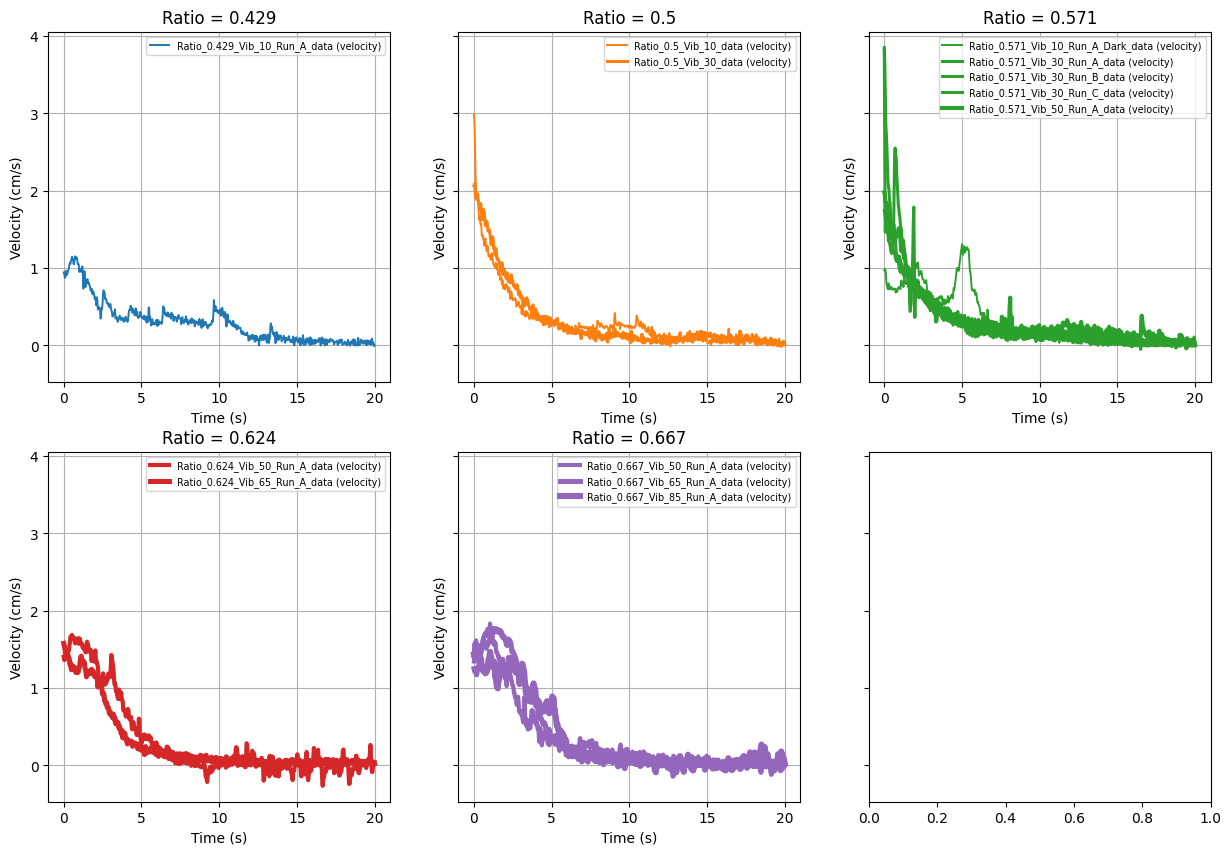

In [10]:
# @interact(a=(1,5,0.1))
# def animate(a=1):
plot_trials_by_ratio_subplots(results, vib_power_map, ppcm=ppcm,
                              limit_type='time', limit_val=20,
                              x_axis_type='time', plot_derivative=True,
                            start_disp_threshold_cm=1.75, max=True,
                            w_size=11, poly_o=2)



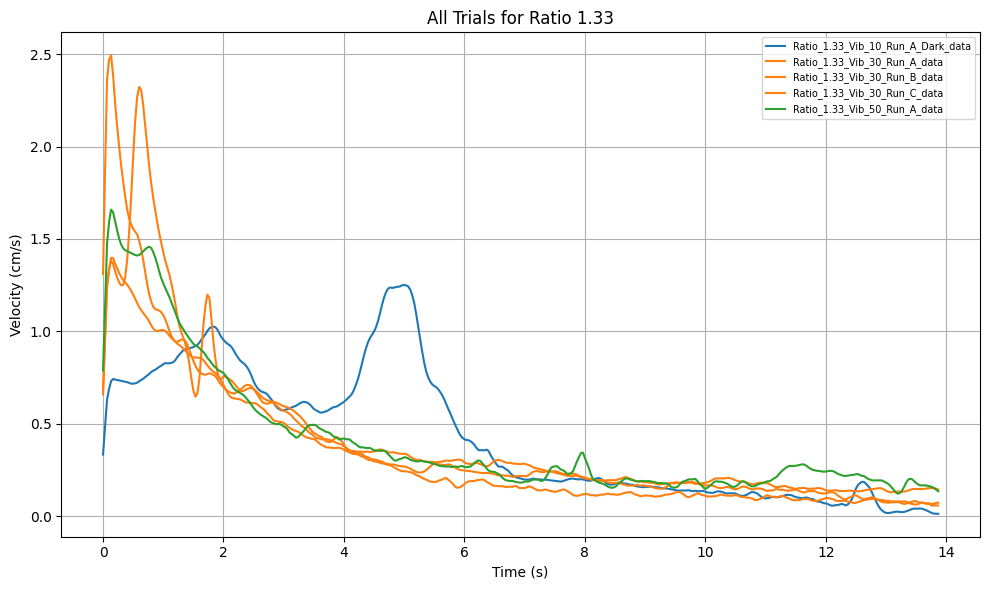

In [ ]:
def compare_trials_by_ratio(
    results, target_ratio=1.33, ppcm=31.5, start_disp_threshold_cm=0,
    plot_deriv=False, stop_time=None, n_neighbors=1, trim_end=0
):
    fig, ax = plt.subplots(figsize=(10, 6))

    # --- Create unique color for each vib level ---
    vib_levels = sorted({int(data['vib']) for data in results.values() if abs(data['ratio'] - target_ratio) < 1e-2})
    color_map = {vib: plt.get_cmap("tab10")(i % 10) for i, vib in enumerate(vib_levels)}

    for filename, data in results.items():
        if abs(data['ratio'] - target_ratio) >= 1e-2:
            continue

        vib = int(data['vib'])
        vertical_disp = data['vertical_mean'] / ppcm
        time = np.arange(0, len(vertical_disp) / 30, 1 / 30)

        # --- Apply displacement threshold ---
        start_idx = np.argmax(vertical_disp >= start_disp_threshold_cm)
        if vertical_disp[start_idx] < start_disp_threshold_cm:
            continue

        vertical_disp = vertical_disp[start_idx:] - vertical_disp[start_idx]
        time = time[start_idx:] - time[start_idx]

        # --- Apply stop_time if given ---
        if stop_time is not None:
            valid_idx = time <= stop_time
            time = time[valid_idx]
            vertical_disp = vertical_disp[valid_idx]

         # --- Apply rolling average if n_neighbors > 1 ---
        if n_neighbors > 1:
            kernel = np.ones(n_neighbors) / n_neighbors
            vertical_disp = np.convolve(vertical_disp, kernel, mode='same')

          # --- Trim end if needed ---
        if trim_end > 0:
            time = time[:-trim_end]
            vertical_disp = vertical_disp[:-trim_end]
        
        label = os.path.splitext(filename)[0]
        color = color_map[vib]

        if plot_deriv and len(time) > 1:
            d_disp = np.gradient(vertical_disp)
            d_time = np.gradient(time)
            velocity = np.divide(d_disp, d_time, out=np.zeros_like(d_disp), where=d_time != 0)
            if n_neighbors > 1:
                velocity = np.convolve(velocity, kernel, mode='same')

            if trim_end > 0:
                time = time[:-trim_end]
                velocity = velocity[:-trim_end]
            ax.plot(time, velocity, label=label, color=color)
            ax.set_ylabel("Velocity (cm/s)")
        else:
            ax.plot(time, vertical_disp + start_disp_threshold_cm, label=label, color=color)
            ax.set_ylabel("Vertical Displacement (cm)")

    ax.set_title(f"All Trials for Ratio {target_ratio}")
    ax.set_xlabel("Time (s)")
    ax.legend(fontsize='x-small', loc='best')
    ax.grid(True)
    plt.tight_layout()
    plt.show()



compare_trials_by_ratio(results=results, start_disp_threshold_cm = 2, plot_deriv=True, stop_time=14, n_neighbors= 5, trim_end=2)

### Same thing but animate across an input

In [ ]:
start = 1 
stop = 4
resolution = 40
slider_vals = np.linspace(start, stop, resolution)
# for i in range(len(slider_vals)):
#     slider_val = slider_vals[i]
#     plot_trials_by_ratio_subplots(results, vib_power_map, ppcm=ppcm,
#                               limit_type='displacement', limit_val=slider_val,
#                               x_axis_type='time', plot_derivative=False,
#                             start_disp_threshold_cm=1.75, max=False)


## The Procesing continues

Ratio_0.75_Vib_10_Run_A_data.pkl: Ratio = 0.75, Vib Power = 10.0, Runtime = 19.3s
Ratio_1.33_Vib_10_Run_A_Dark_data.pkl: Ratio = 1.33, Vib Power = 10.0, Runtime = 16.8s
Ratio_1.33_Vib_30_Run_A_data.pkl: Ratio = 1.33, Vib Power = 30.0, Runtime = 15.0s
Ratio_1.33_Vib_30_Run_B_data.pkl: Ratio = 1.33, Vib Power = 30.0, Runtime = 20.1s
Ratio_1.33_Vib_30_Run_C_data.pkl: Ratio = 1.33, Vib Power = 30.0, Runtime = 21.6s
Ratio_1.33_Vib_50_Run_A_data.pkl: Ratio = 1.33, Vib Power = 50.0, Runtime = 21.0s
Ratio_1.66_Vib_50_Run_A_data.pkl: Ratio = 1.66, Vib Power = 50.0, Runtime = 20.6s
Ratio_1.66_Vib_65_Run_A_data.pkl: Ratio = 1.66, Vib Power = 65.0, Runtime = 20.4s
Ratio_1_Vib_10_data.pkl: Ratio = 1.0, Vib Power = 10.0, Runtime = 17.2s
Ratio_1_Vib_30_data.pkl: Ratio = 1.0, Vib Power = 30.0, Runtime = 23.2s
Ratio_2_Vib_50_Run_A_data.pkl: Ratio = 2.0, Vib Power = 50.0, Runtime = 18.7s
Ratio_2_Vib_65_Run_A_data.pkl: Ratio = 2.0, Vib Power = 65.0, Runtime = 27.8s
Ratio_2_Vib_85_Run_A_data.pkl: Ratio = 

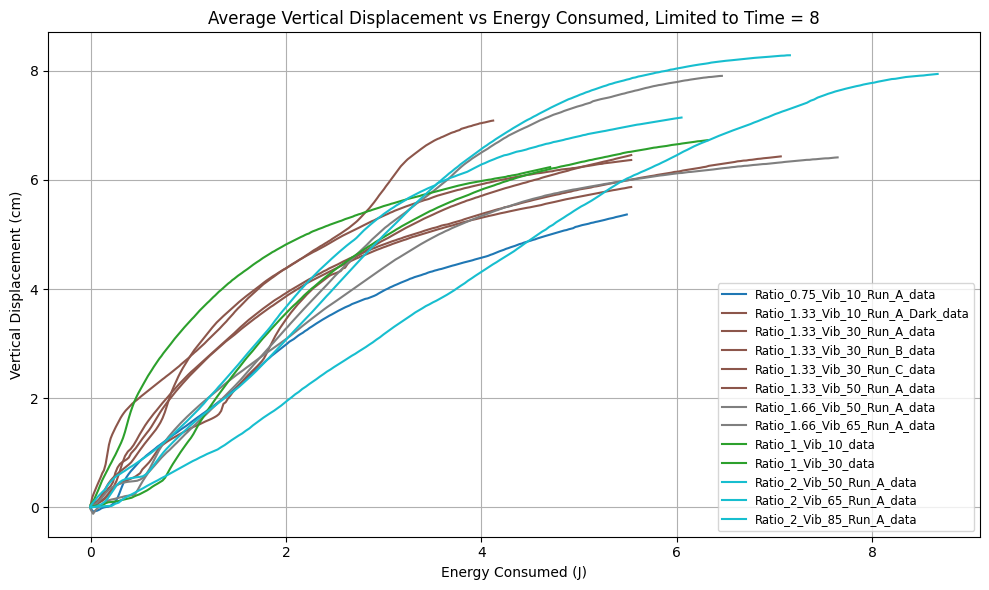

In [ ]:
# Load Preprocessed data

folder_path =  r"C:\Users\La Calculadora\Documents\Illimited\VibData"
file_name = "cum_pp_displacement_data.pkl"

# --- Gather all pickle files ---
pppickle_file = load_path = os.path.join(folder_path, file_name)


# Load results
with open(load_path, 'rb') as f:
    results = pickle.load(f)

# Now you can access data like:
for file_name, data in results.items():
    ratio = data['ratio']
    color = data['color']
    vib = data['vib']
    vertical_mean = data['vertical_mean']         # numpy array of averaged trimmed data
    trimmed_raw = data['trimmed_raw']             # list of individual trimmed displacement runs
    
    # Example: print summary
    print(f"{file_name}: Ratio = {ratio}, Vib Power = {vib}, Runtime = {len(vertical_mean)/60:.1f}s")




test = vib_power_map.get(35)
print(f"Power at 35%: {test}W")


limit_type = "Time"  # Options: "Energy", "Time", or "None"
limit_val = 8  # Either energy in Joules or time in seconds

fig, ax = plt.subplots(figsize=(10, 6))

for filename, data in results.items():
    power_ratio = data['ratio']
    vib_percent = int(data['vib'])
    vib_power = vib_power_map.get(vib_percent)
    total_power = vib_power * ( 1 + 1/power_ratio)
    vertical_disp = data['vertical_mean']/ppcm

    time = np.arange(0,len(vertical_disp)/30, 1/30)
    total_energy_consumed = time * total_power

        # --- Apply limit based on parameter ---
    if limit_type.lower() == "time":
        valid_idx = time <= limit_val
    elif limit_type.lower() == "energy":
        valid_idx = total_energy_consumed <= limit_val
    else:  # no limit
        valid_idx = np.ones_like(time, dtype=bool)

    label = os.path.splitext(filename)[0]
    color = data['color']
    ax.plot(total_energy_consumed[valid_idx], vertical_disp[valid_idx], label=label, color=color)
    
ax.set_title(f"Average Vertical Displacement vs Energy Consumed, Limited to {limit_type} = {limit_val}")
ax.set_xlabel("Energy Consumed (J)")
ax.set_ylabel("Vertical Displacement (cm)")
ax.grid(True)
ax.legend(fontsize='small', loc='best')

plt.tight_layout()
plt.show()




In [11]:
def plot_energy_vs_displacement(
    results,
    vib_power_map,
    ppcm,
    limit_type="none",
    limit_val=10,
    average_ratios=False,
    plot_derivative=False,
    w_size = 11, poly_o = 3
):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Grouped data by power_ratio if averaging
    grouped = {}

    for filename, data in results.items():
        power_ratio = data['ratio']
        vib_percent = int(data['vib'])
        vib_power = vib_power_map.get(vib_percent)
        total_power = vib_power * (1 + 1 / power_ratio)
        vertical_disp = data['vertical_mean'] / ppcm

        time = np.arange(0, len(vertical_disp) / 30, 1 / 30)
        total_energy_consumed = time * total_power

        # --- Apply limit based on parameter ---
        if limit_type.lower() == "time":
            valid_idx = time <= limit_val
        elif limit_type.lower() == "energy":
            valid_idx = total_energy_consumed <= limit_val
        else:
            valid_idx = np.ones_like(time, dtype=bool)

        energy_limited = total_energy_consumed[valid_idx]
        disp_limited = vertical_disp[valid_idx]

        if average_ratios:
            key = round(power_ratio, 3)
            if key not in grouped:
                grouped[key] = []
            grouped[key].append((energy_limited, disp_limited))
        else:
            label = os.path.splitext(filename)[0]
            color = data['color']
            if plot_derivative:
                d_disp = np.diff(disp_limited)
                d_energy = np.diff(energy_limited)
                deriv = np.divide(d_energy, d_disp, out=np.zeros_like(d_energy), where=d_disp!=0)
                ax.plot(disp_limited[1:], deriv, label=f"{label} (dE/dx)", color=color)
            else:
                ax.plot(energy_limited, disp_limited, label=label, color=color)

    # --- Averaged Plot ---
    if average_ratios:
        for power_ratio, trials in grouped.items():
            min_len = min(len(x[0]) for x in trials)
            truncated_energy = np.array([x[0][:min_len] for x in trials])
            truncated_disp = np.array([x[1][:min_len] for x in trials])
            avg_energy = np.mean(truncated_energy, axis=0)
            avg_disp = np.mean(truncated_disp, axis=0)

            if plot_derivative:
                d_disp = np.diff(avg_disp)
                d_energy = np.diff(avg_energy)
                deriv = np.divide(d_energy, d_disp, out=np.zeros_like(d_energy), where=d_disp!=0)
                deriv = savgol_filter(deriv, w_size, poly_o)
                ax.plot(avg_disp[1:], deriv, label=f"Ratio {power_ratio} (dE/dx)", linewidth=2)
            else:
                ax.plot(avg_energy, avg_disp, label=f"Ratio {power_ratio}", linewidth=2)

    # --- Labels ---
    if plot_derivative:
        ax.set_title(f"Energy per cm vs Displacement\nLimit: {limit_type.capitalize()} = {limit_val}")
        ax.set_xlabel("Vertical Displacement (cm)")
        ax.set_ylabel("Energy per depth (J/cm)")
    else:
        ax.set_title(f"Vertical Displacement vs Energy Consumed\nLimit: {limit_type.capitalize()} = {limit_val}")
        ax.set_xlabel("Energy Consumed (J)")
        ax.set_ylabel("Vertical Displacement (cm)")

    ax.grid(True)
    ax.legend(fontsize='small', loc='best')
    ax.set_ybound(0,5.5)
    plt.tight_layout()
    plt.show()


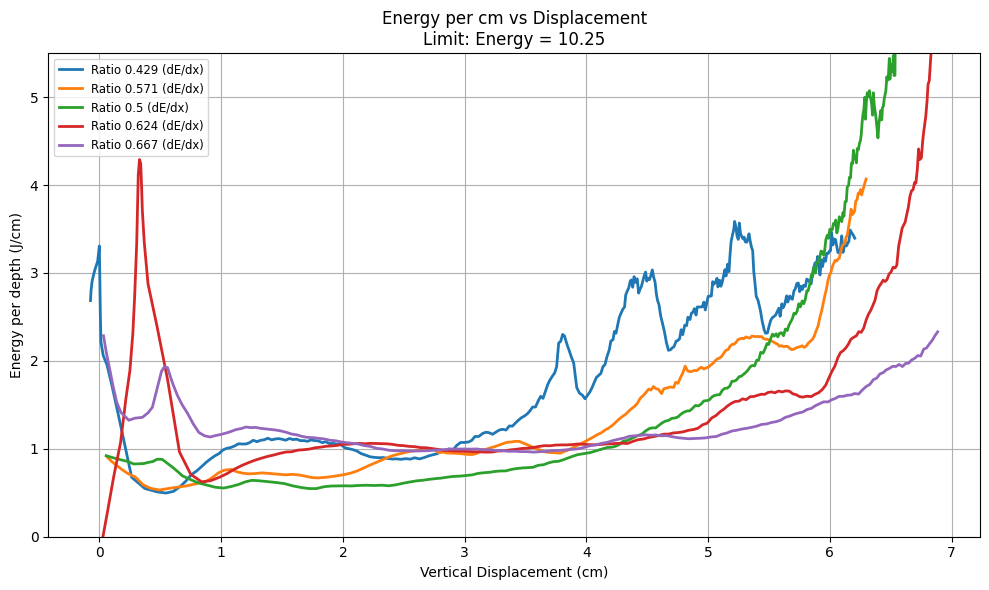

In [22]:
plot_energy_vs_displacement(
    results=results,
    vib_power_map=vib_power_map,
    ppcm=ppcm,
    limit_type="Energy", # Time or Energy
    limit_val=10.25,    # Limit by time or energy
    average_ratios=True, # plot the aaverage per ratios
    plot_derivative=True, # plots local energy cost
    w_size = 9, poly_o = 1 # Smoothing variables
)

